In [257]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [258]:
df = pd.read_csv('data/final_combined_dataset.csv')

In [259]:
# geocode_list = [3303807]
# df = df[df['geocode'].isin(geocode_list)]

In [260]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

In [261]:
# Define outbreak categories based on cases_per_100k thresholds
bins = [0, 50, 100, 150, 200]
labels = ['No', 'Mild', 'Moderate', 'High']

# Create the 'outbreak' column
df['outbreak'] = pd.cut(df['cases_per_100k'], bins=bins, labels=labels, right=False)

In [262]:
# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0, 1])

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases_per_100k', lags=[0, 1])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(data, group_col='city', target_col=weather_columns, lags=[0, 1, 2, 3, 4])

# data = create_lags(data, group_col='city', target_col='nearby_cases_weighted', lags=[4])

# lag cases -4 weeks
data = create_lags(data, group_col='city', target_col='cases_per_100k', lags=[-2], inplace = True)

data = data.dropna().reset_index(drop=True)

In [263]:
# Step 4: Scale continuous variables, including lagged variables
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

continuous_vars = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging',
                'nearby_cases_weighted']
# Include lagged variables in the scaling process
lagged_vars = [col for col in data.columns if '_lag' in col]
scaler_vars = continuous_vars + lagged_vars
# data[scaler_vars] = feature_scaler.fit_transform(data[scaler_vars])
# 
# # Scale the target variable
# scaled_cases = target_scaler.fit_transform(data[['cases_per_100k']])
# data['scaled_cases'] = scaled_cases

In [264]:
# Step 5: Split the data into training and testing sets based on time
train_data = data[(data['week'] >= 201201) & (data['week'] <= 202052)]
test_data = data[(data['week'] > 202052)]

columns_exclude = ['date', 'cases', 'scaled_cases', 'geocode', 'lat', 'long', 'population', 'cases_per_100k', 'year', 'month']

# Prepare X (features)
X_train = train_data[[col for col in data.columns if col not in columns_exclude]]
X_test = test_data[[col for col in data.columns if col not in columns_exclude]]

# Prepare y (target variable)
y_train = train_data['outbreak']
y_test = test_data['outbreak']

# Convert categorical target variable to numerical labels
y_train = y_train.astype('category').cat.codes  # No=0, Mild=1, Moderate=2, High=3
y_test = y_test.astype('category').cat.codes

# Scale features
X_train[scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
X_test[scaler_vars] = feature_scaler.transform(X_test[scaler_vars])


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21980\226076802.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21980\226076802.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[scaler_vars] = feature_scaler.transform(X_test[scaler_vars])


In [265]:
from sklearn.preprocessing import LabelEncoder

# Ensure you're working with a copy of the DataFrame if necessary
X_train = X_train.copy()  # If it's a slice, we create a new copy
X_test = X_test.copy()    # Same here

# Step 1: Encode the city column
label_encoder = LabelEncoder()
X_train['city_encoded'] = label_encoder.fit_transform(X_train['city'])
X_test['city_encoded'] = label_encoder.transform(X_test['city'])

# Step 2: Drop the original city column
X_train = X_train.drop(columns=['city'])
X_test = X_test.drop(columns=['city'])

In [266]:
# Step 6: Prepare LightGBM datasets
train_dataset = lgb.Dataset(X_train, label=y_train)
test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

In [267]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Step 7: Define LightGBM parameters for classification
params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_class': 4,  # Four outbreak categories
    'verbose': -1
}

# Step 8: Train the model with early stopping
callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
model = lgb.train(params, train_dataset, valid_sets=[train_dataset, test_dataset],
                  num_boost_round=1000, callbacks=callbacks)

# Step 9: Make predictions
probs = model.predict(X_test, num_iteration=model.best_iteration)  # Probabilities for each class
y_pred = np.argmax(probs, axis=1)  # Convert probabilities to class labels

# Step 10: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred, target_names=['No', 'Mild', 'Moderate', 'High']))

# Step 11: Save the model
model.save_model('lightgbm_dengue_model.txt')


Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 4.02285e-05	valid_1's multi_logloss: 2.83432e-05
[200]	training's multi_logloss: 9.03325e-08	valid_1's multi_logloss: 4.07058e-08
[300]	training's multi_logloss: 8.49001e-08	valid_1's multi_logloss: 3.78244e-08
Early stopping, best iteration is:
[285]	training's multi_logloss: 8.5054e-08	valid_1's multi_logloss: 3.76725e-08
Accuracy: 1.0000
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      9266
        Mild       1.00      1.00      1.00        79
    Moderate       1.00      1.00      1.00        18
        High       1.00      1.00      1.00         2

    accuracy                           1.00      9365
   macro avg       1.00      1.00      1.00      9365
weighted avg       1.00      1.00      1.00      9365



Top 10 Most Important Features:
                  Feature  Importance
22    cases_per_100k_lag0        3142
23    cases_per_100k_lag1        2300
20             cases_lag0        1579
19               outbreak        1440
21             cases_lag1         967
17               week_sin         621
13  nearby_cases_weighted         360
74           city_encoded         353
18               week_cos         335
0                    week         271


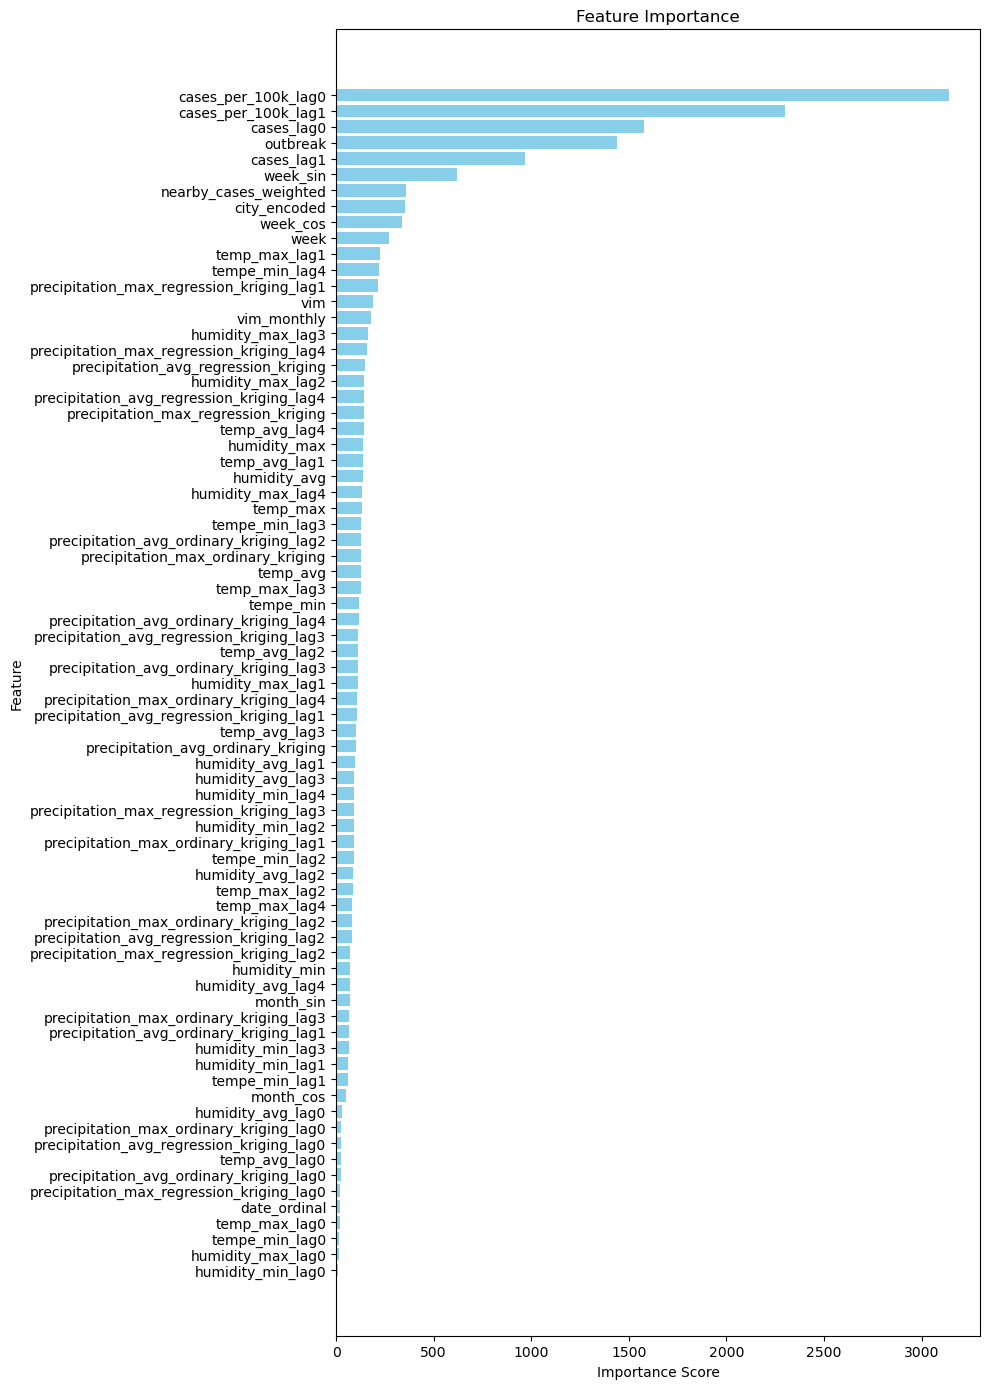

In [268]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for feature importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance()
})

# Sort by importance
importance = importance.sort_values(by='Importance', ascending=False)

# Print top features in a neat table
print("Top 10 Most Important Features:")
print(importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 14))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()


Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      9266
        Mild       1.00      1.00      1.00        79
    Moderate       1.00      1.00      1.00        18
        High       1.00      1.00      1.00         2

    accuracy                           1.00      9365
   macro avg       1.00      1.00      1.00      9365
weighted avg       1.00      1.00      1.00      9365

Confusion Matrix:
[[9266    0    0    0]
 [   0   79    0    0]
 [   0    0   18    0]
 [   0    0    0    2]]


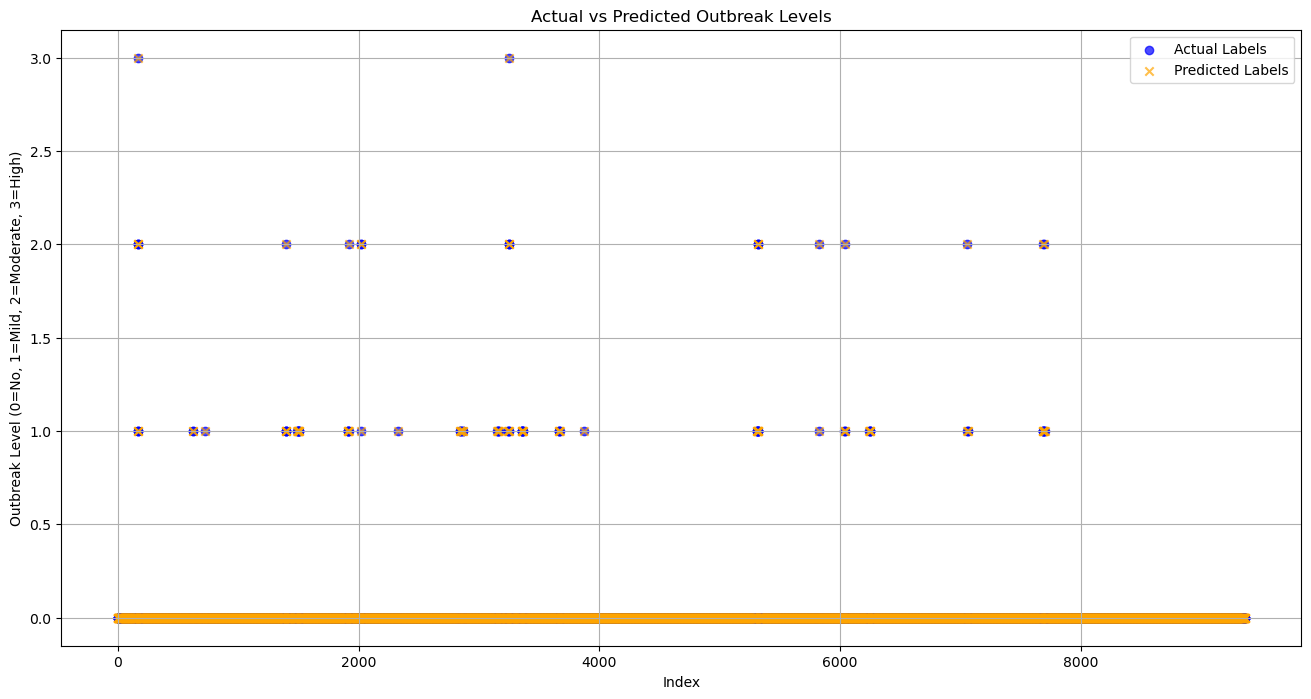

In [269]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Evaluate the classification performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No', 'Mild', 'Moderate', 'High']))

# Step 2: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Step 3: Plot Actual vs Predicted Labels
plt.figure(figsize=(16, 8))
plt.scatter(np.arange(len(y_test)), y_test, label='Actual Labels', color='blue', alpha=0.7, marker='o')
plt.scatter(np.arange(len(y_pred)), y_pred, label='Predicted Labels', color='orange', alpha=0.7, marker='x')

plt.xlabel('Index')
plt.ylabel('Outbreak Level (0=No, 1=Mild, 2=Moderate, 3=High)')
plt.title('Actual vs Predicted Outbreak Levels')
plt.legend()
plt.grid(True)
plt.show()


City: 1, Accuracy: 1.0000
Unique classes for 1: [0 1 2 3]
Classification Report for 1:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        89
        Mild       1.00      1.00      1.00         3
    Moderate       1.00      1.00      1.00         3
        High       1.00      1.00      1.00         1

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Confusion Matrix for 1:
[[89  0  0  0]
 [ 0  3  0  0]
 [ 0  0  3  0]
 [ 0  0  0  1]]


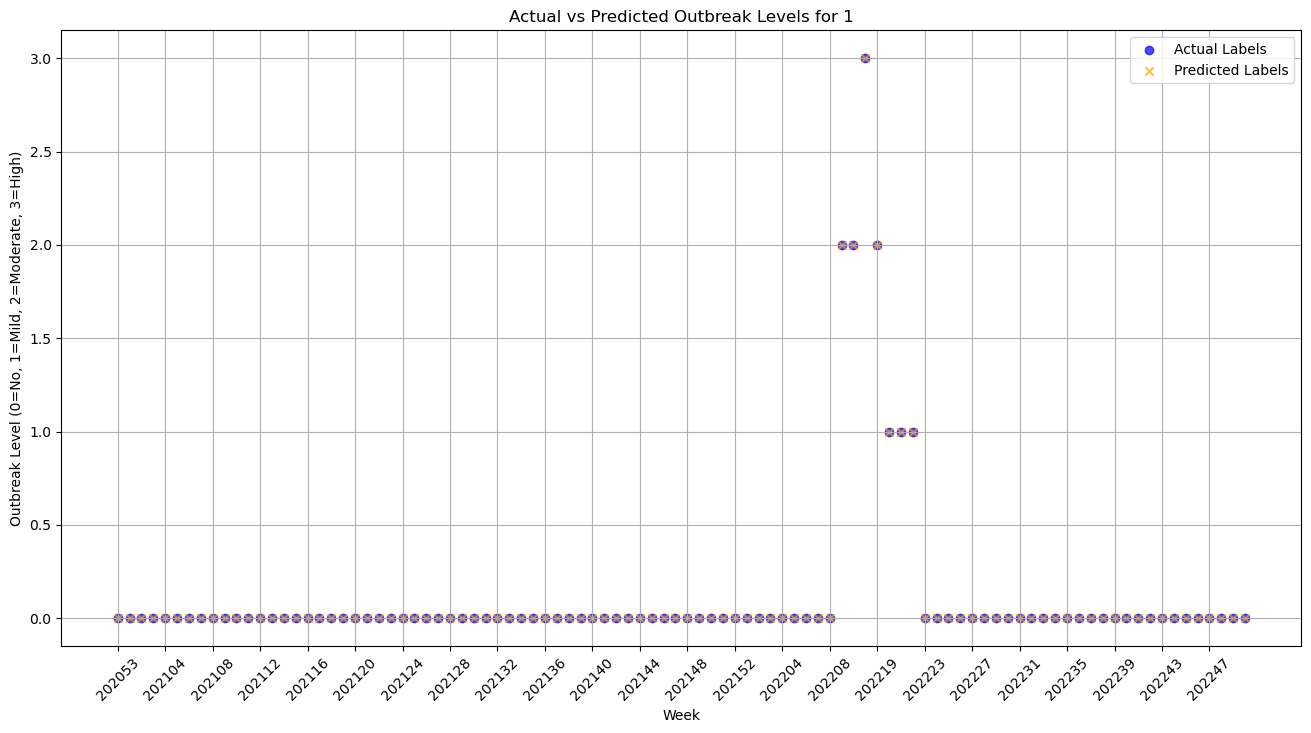

City: 6, Accuracy: 1.0000
Unique classes for 6: [0 1]
Classification Report for 6:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       101
        Mild       1.00      1.00      1.00         2

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 6:
[[101   0]
 [  0   2]]


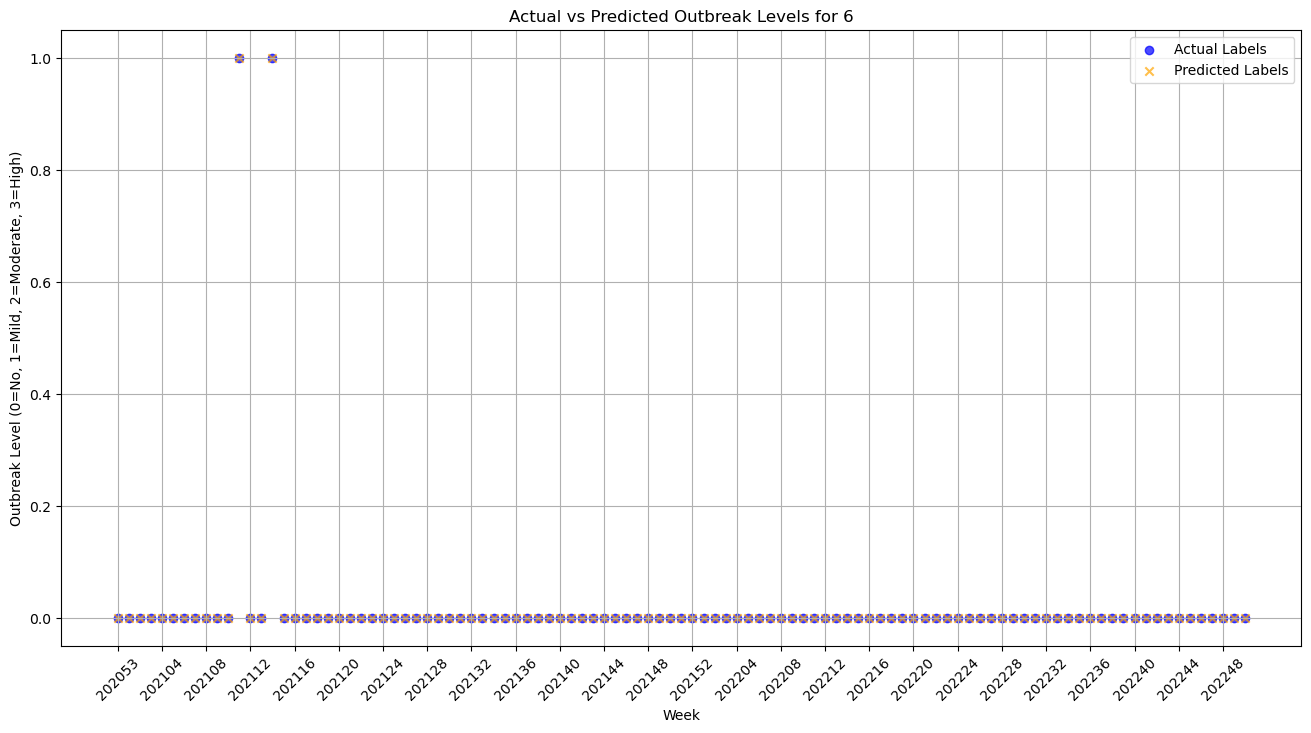

City: 7, Accuracy: 1.0000
Unique classes for 7: [0 1]
Classification Report for 7:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       102
        Mild       1.00      1.00      1.00         1

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 7:
[[102   0]
 [  0   1]]


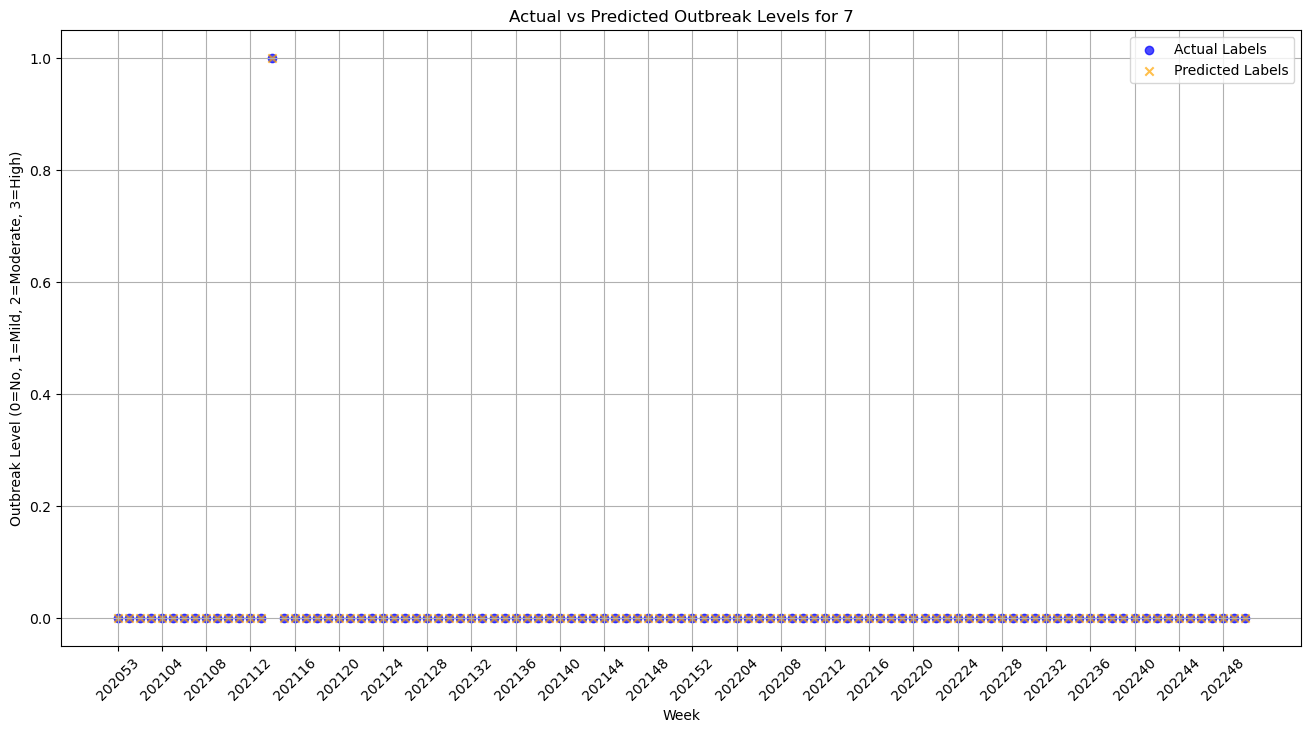

City: 13, Accuracy: 1.0000
Unique classes for 13: [0 1 2]
Classification Report for 13:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        98
        Mild       1.00      1.00      1.00         4
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 13:
[[98  0  0]
 [ 0  4  0]
 [ 0  0  1]]


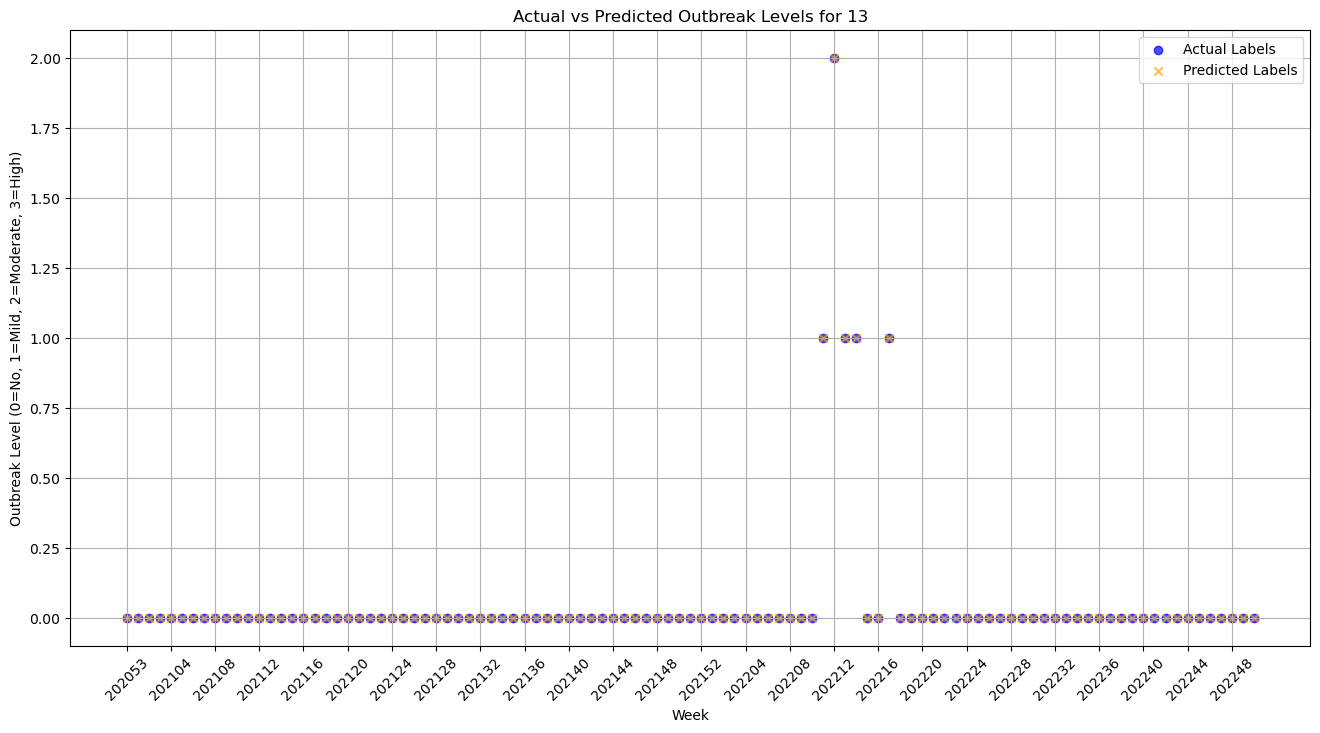

City: 16, Accuracy: 1.0000
Unique classes for 16: [0 1]
Classification Report for 16:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        95
        Mild       1.00      1.00      1.00         8

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 16:
[[95  0]
 [ 0  8]]


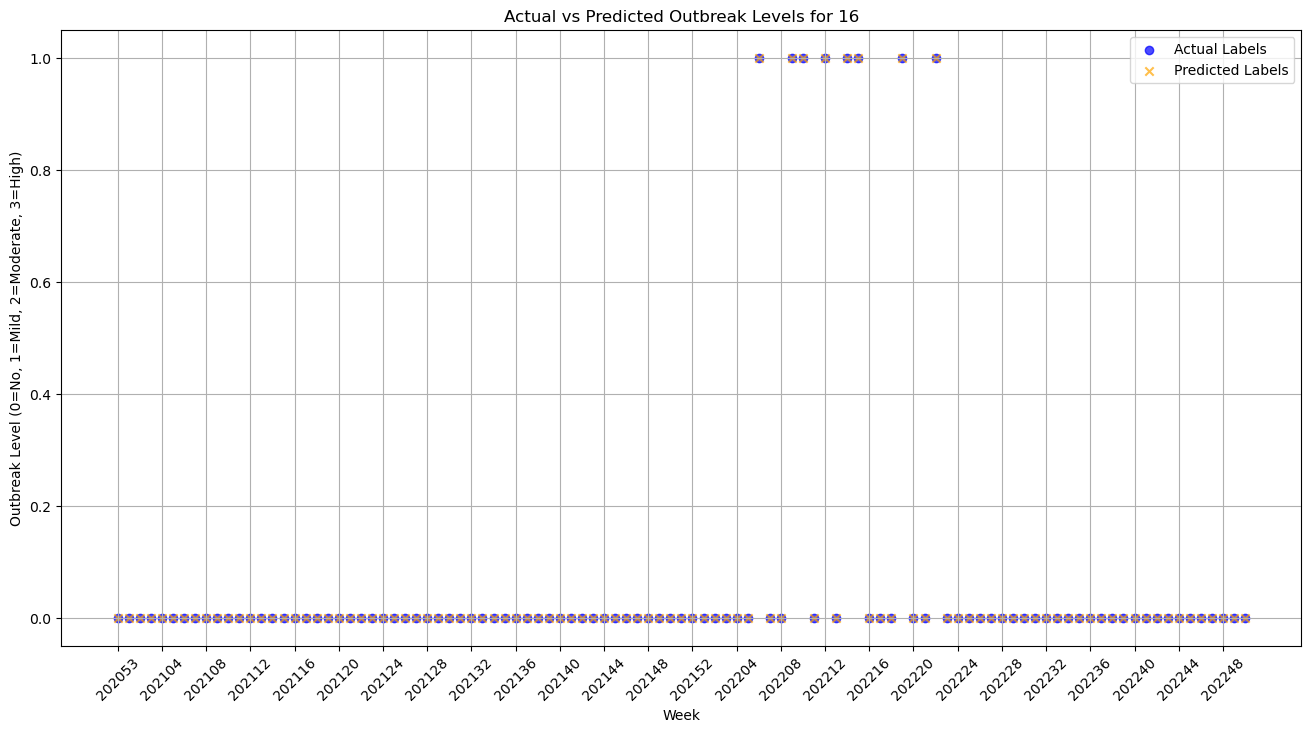

City: 17, Accuracy: 1.0000
Unique classes for 17: [0 1 2]
Classification Report for 17:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        97
        Mild       1.00      1.00      1.00         5
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 17:
[[97  0  0]
 [ 0  5  0]
 [ 0  0  1]]


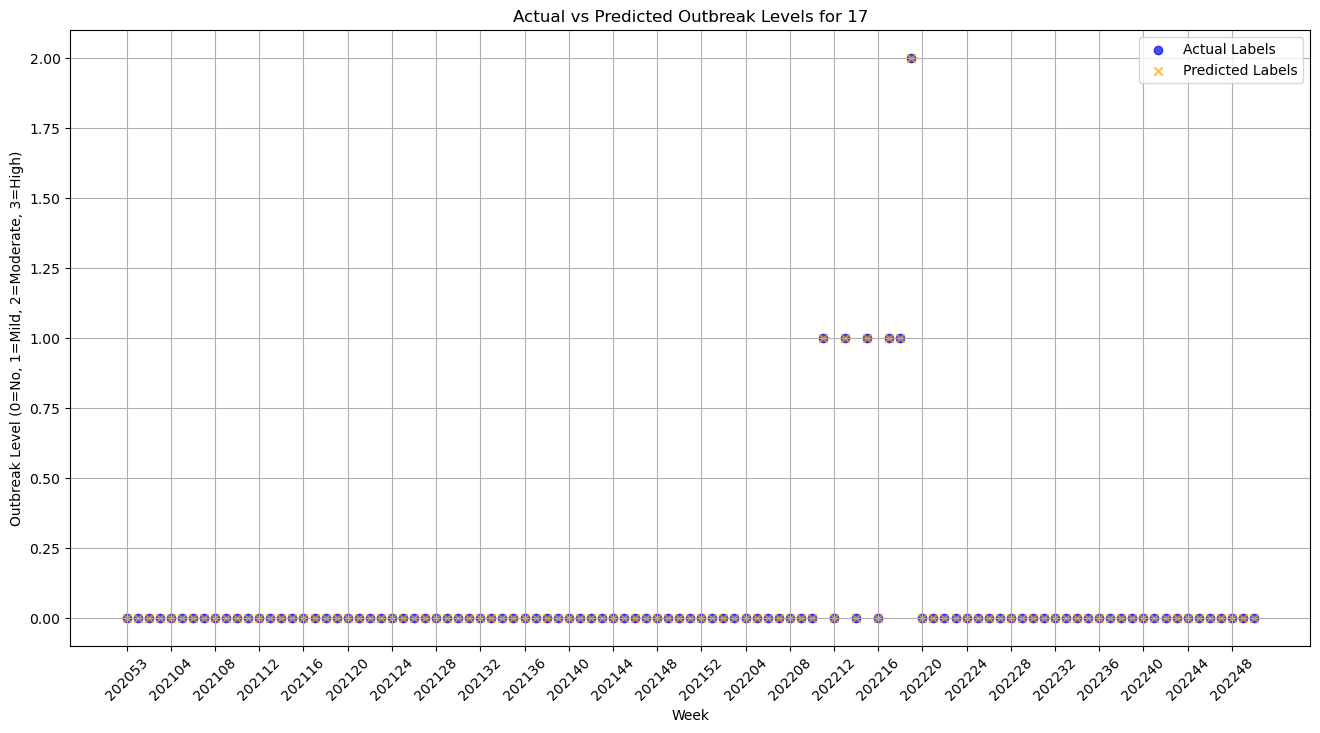

City: 18, Accuracy: 1.0000
Unique classes for 18: [0 1 2]
Classification Report for 18:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        99
        Mild       1.00      1.00      1.00         1
    Moderate       1.00      1.00      1.00         2

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Confusion Matrix for 18:
[[99  0  0]
 [ 0  1  0]
 [ 0  0  2]]


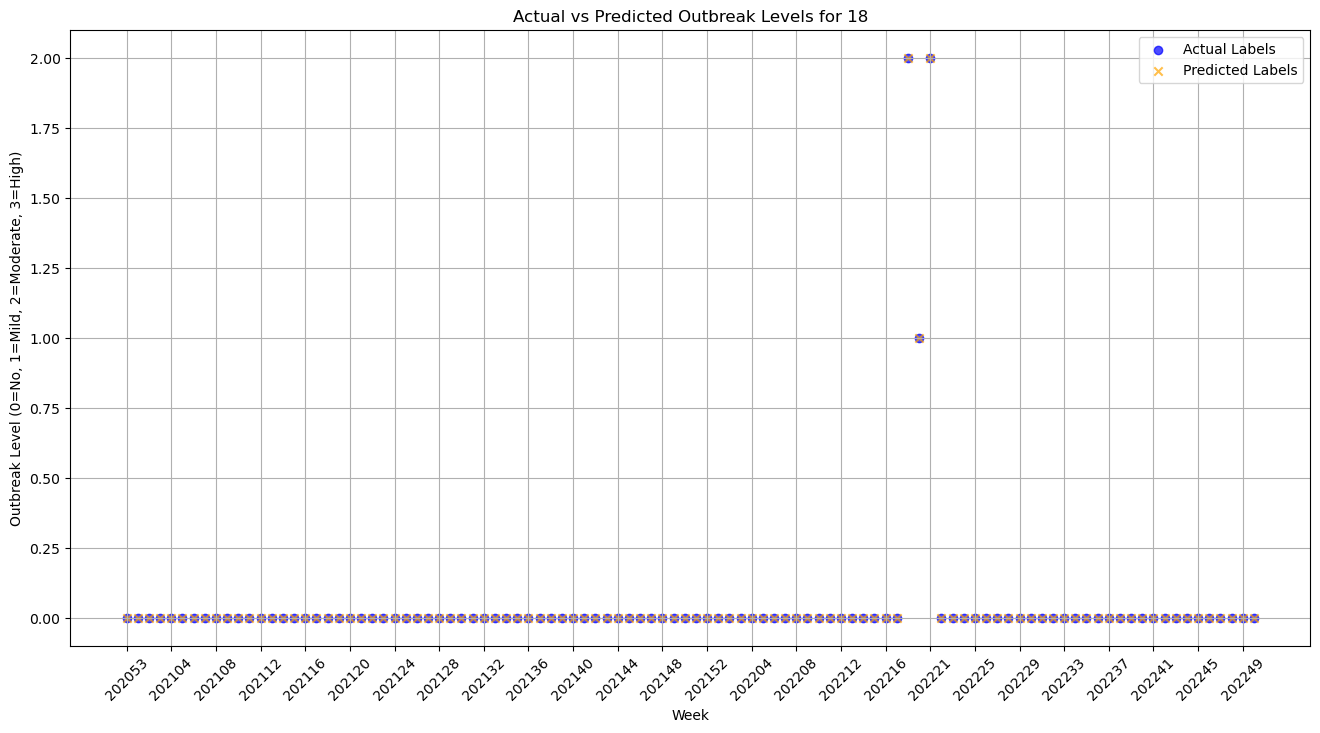

City: 22, Accuracy: 1.0000
Unique classes for 22: [0 1]
Classification Report for 22:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       102
        Mild       1.00      1.00      1.00         1

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 22:
[[102   0]
 [  0   1]]


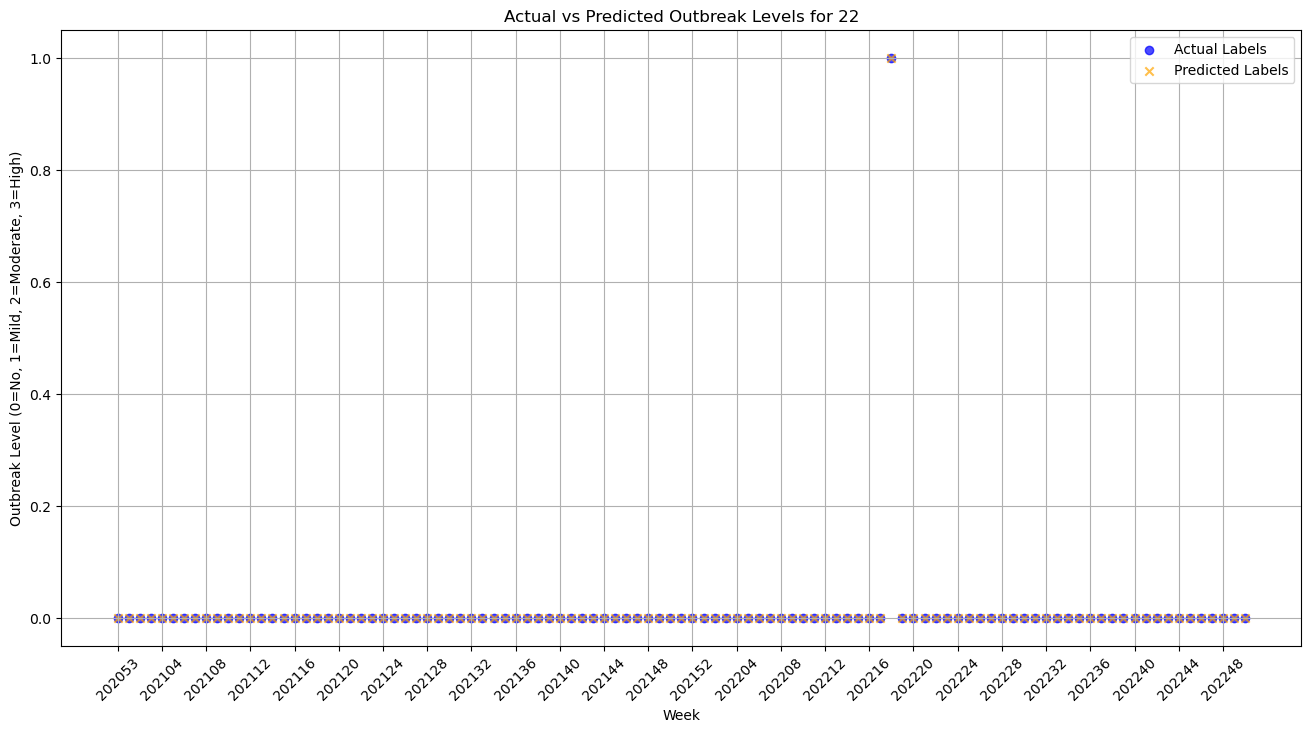

City: 27, Accuracy: 1.0000
Unique classes for 27: [0 1]
Classification Report for 27:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        97
        Mild       1.00      1.00      1.00         6

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 27:
[[97  0]
 [ 0  6]]


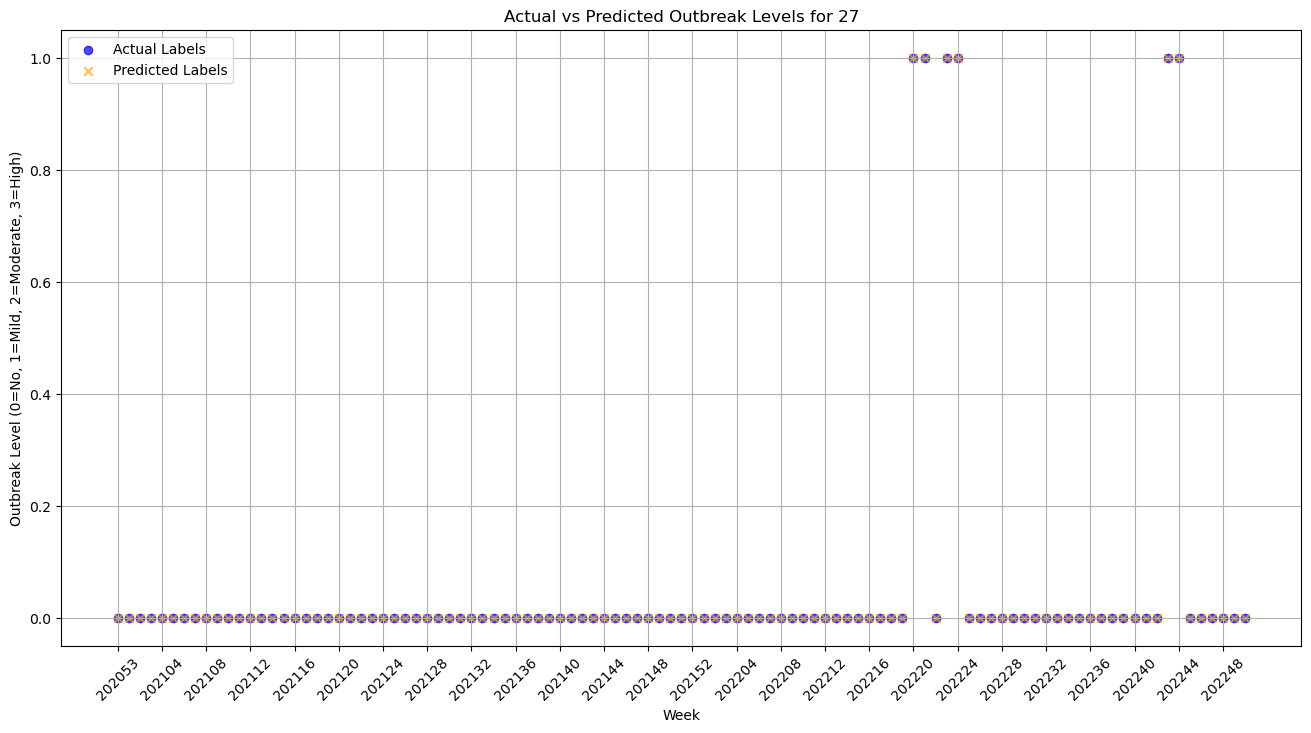

City: 30, Accuracy: 1.0000
Unique classes for 30: [0 1]
Classification Report for 30:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        98
        Mild       1.00      1.00      1.00         5

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 30:
[[98  0]
 [ 0  5]]


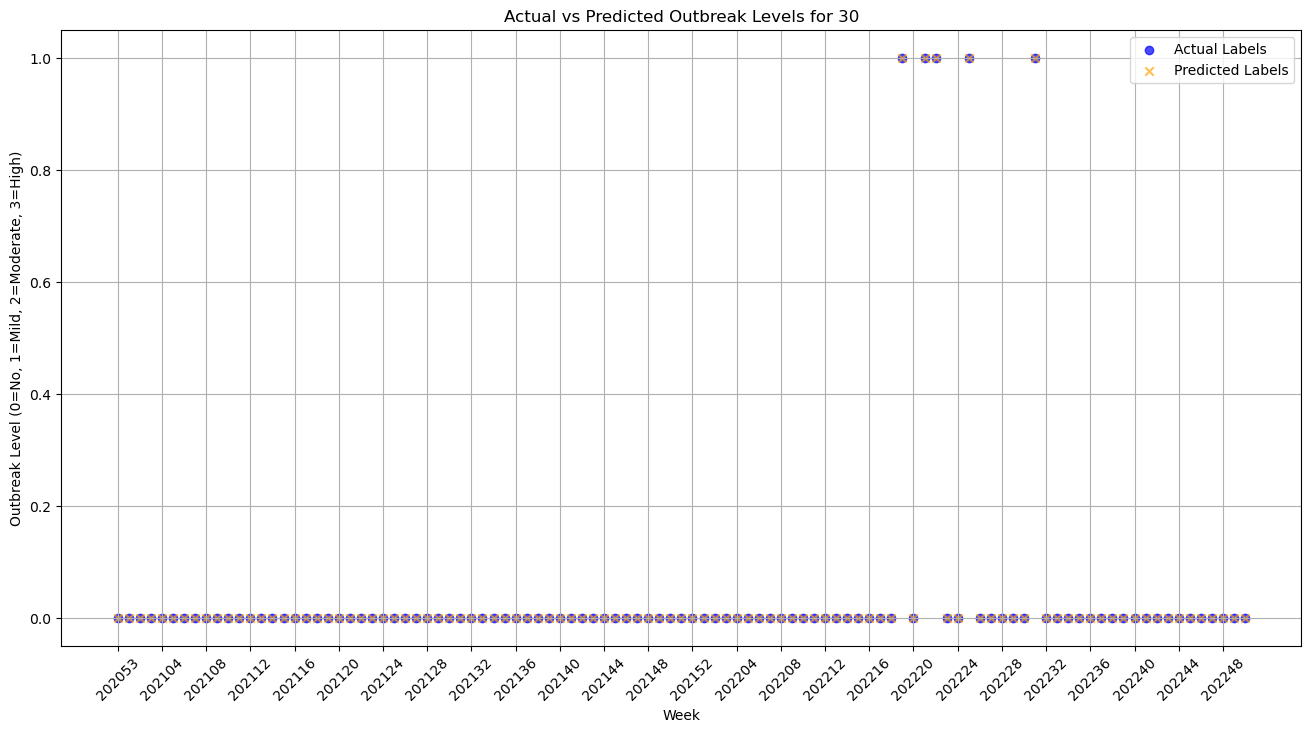

City: 31, Accuracy: 1.0000
Unique classes for 31: [0 1 2 3]
Classification Report for 31:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        95
        Mild       1.00      1.00      1.00         4
    Moderate       1.00      1.00      1.00         3
        High       1.00      1.00      1.00         1

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 31:
[[95  0  0  0]
 [ 0  4  0  0]
 [ 0  0  3  0]
 [ 0  0  0  1]]


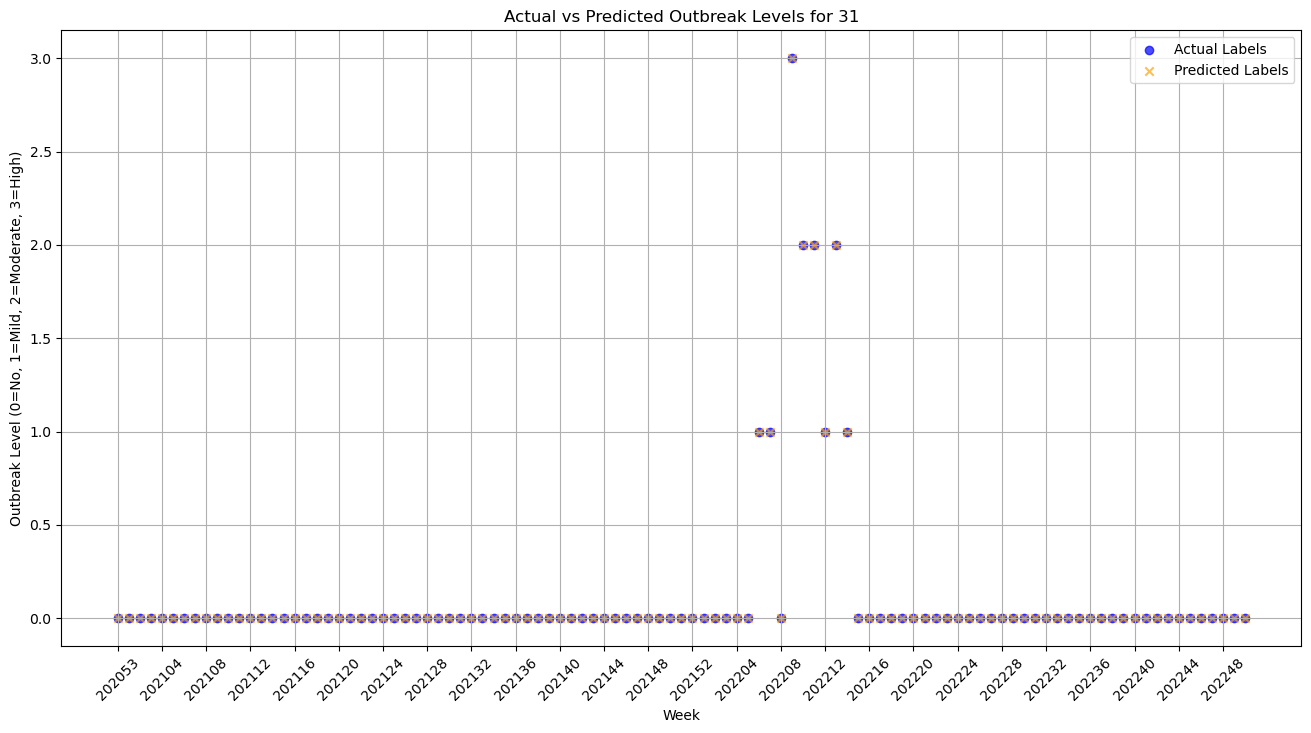

City: 32, Accuracy: 1.0000
Unique classes for 32: [0 1]
Classification Report for 32:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        96
        Mild       1.00      1.00      1.00         7

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 32:
[[96  0]
 [ 0  7]]


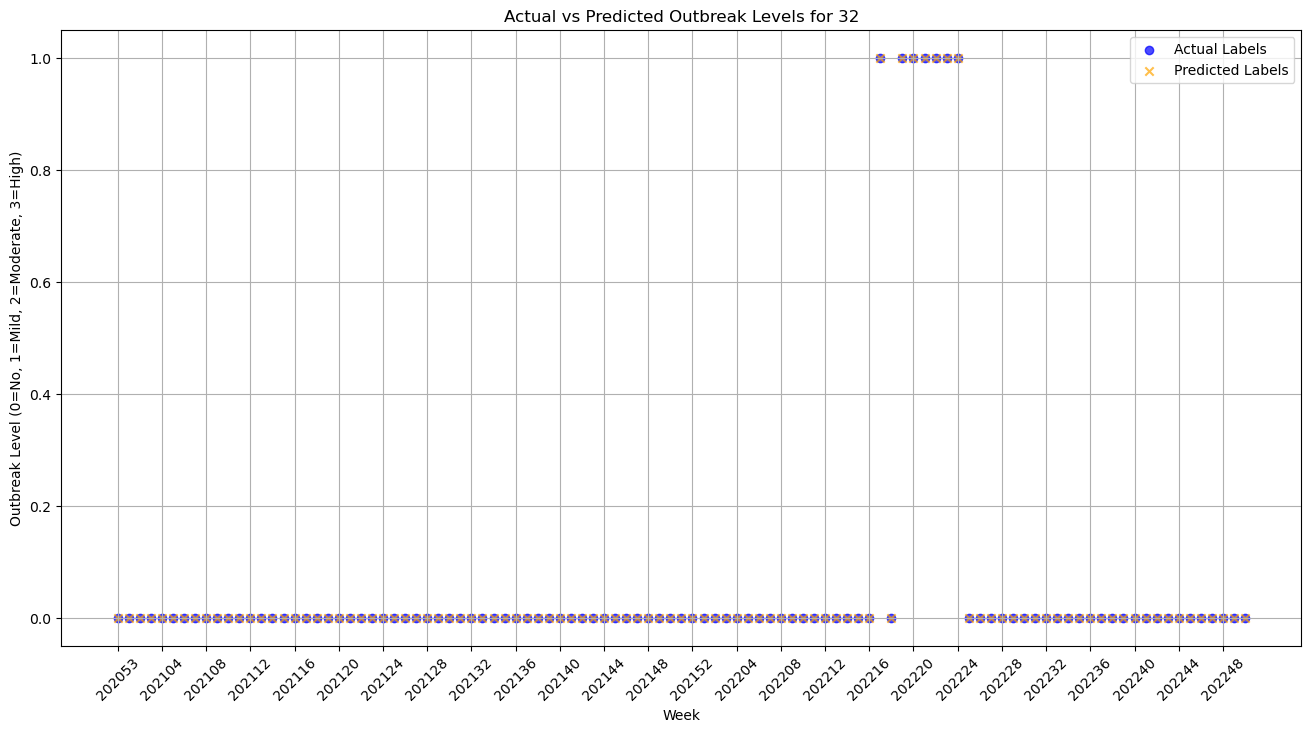

City: 35, Accuracy: 1.0000
Unique classes for 35: [0 1]
Classification Report for 35:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        99
        Mild       1.00      1.00      1.00         4

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 35:
[[99  0]
 [ 0  4]]


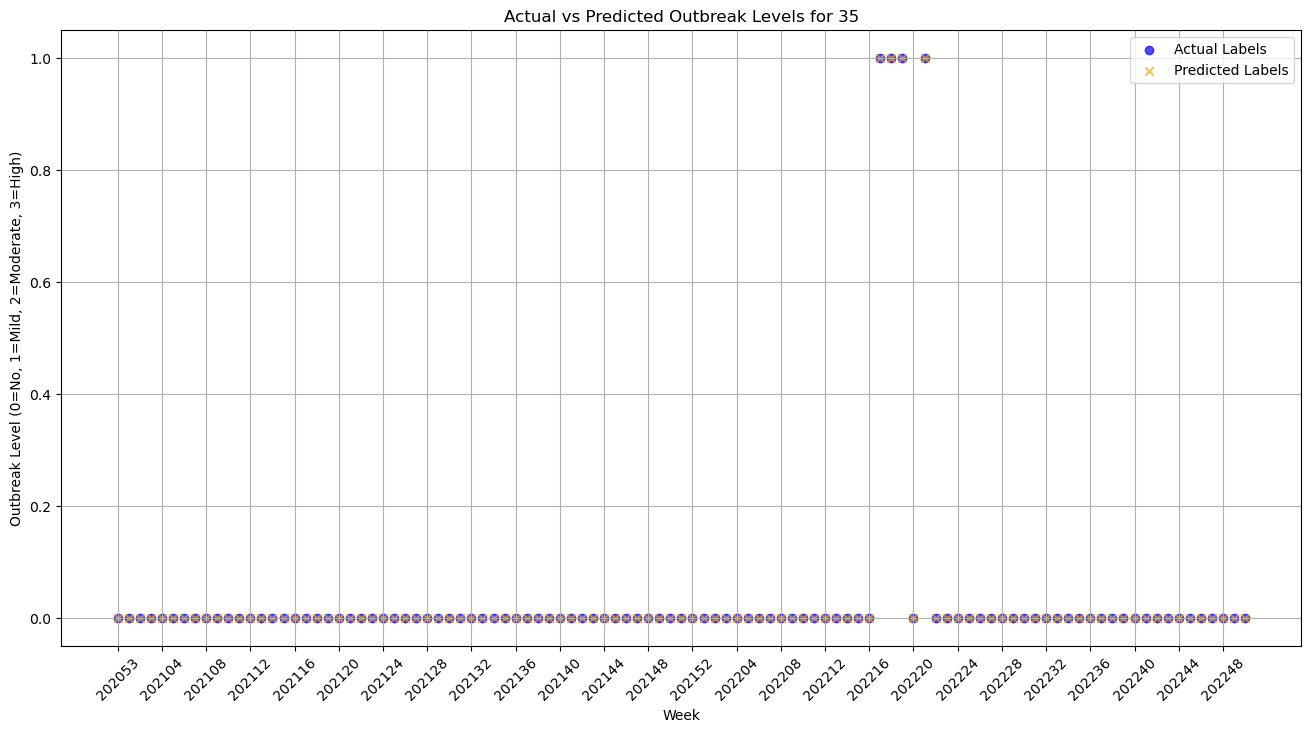

City: 37, Accuracy: 1.0000
Unique classes for 37: [0 1]
Classification Report for 37:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       102
        Mild       1.00      1.00      1.00         1

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 37:
[[102   0]
 [  0   1]]


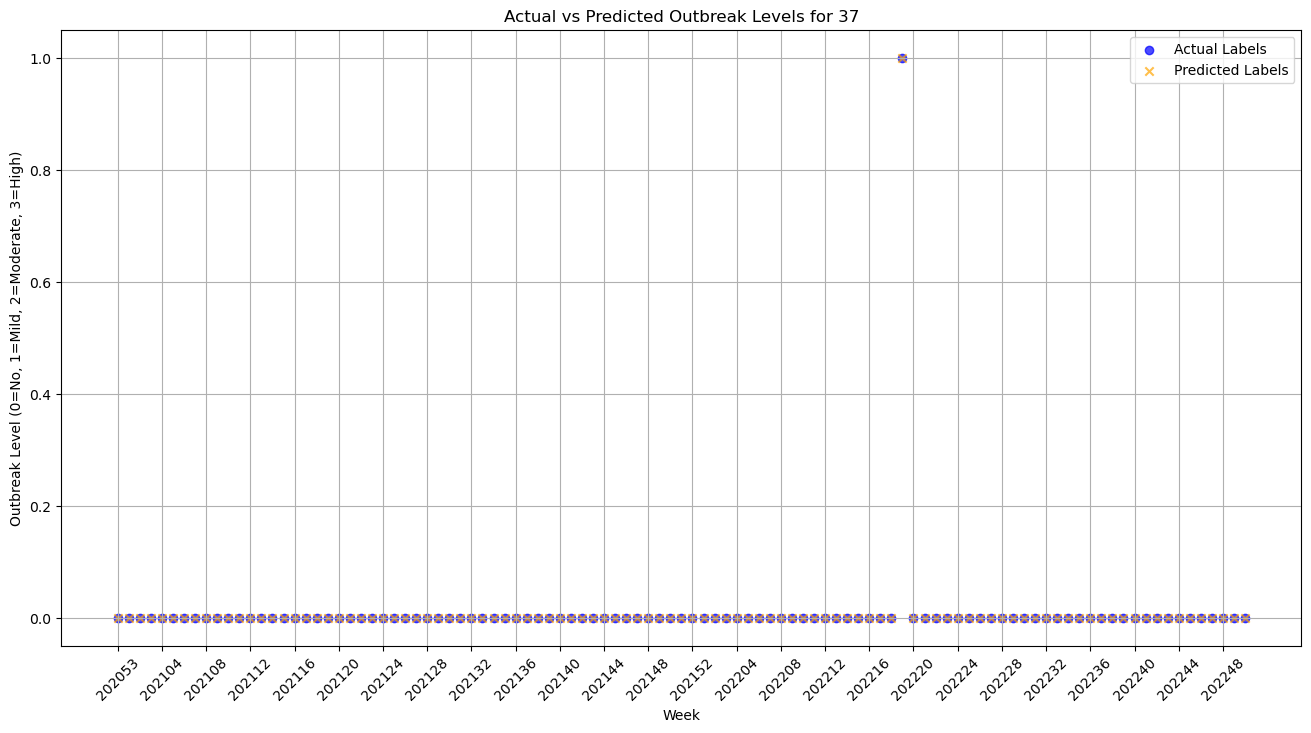

City: 50, Accuracy: 1.0000
Unique classes for 50: [0 1 2]
Classification Report for 50:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        92
        Mild       1.00      1.00      1.00         8
    Moderate       1.00      1.00      1.00         3

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 50:
[[92  0  0]
 [ 0  8  0]
 [ 0  0  3]]


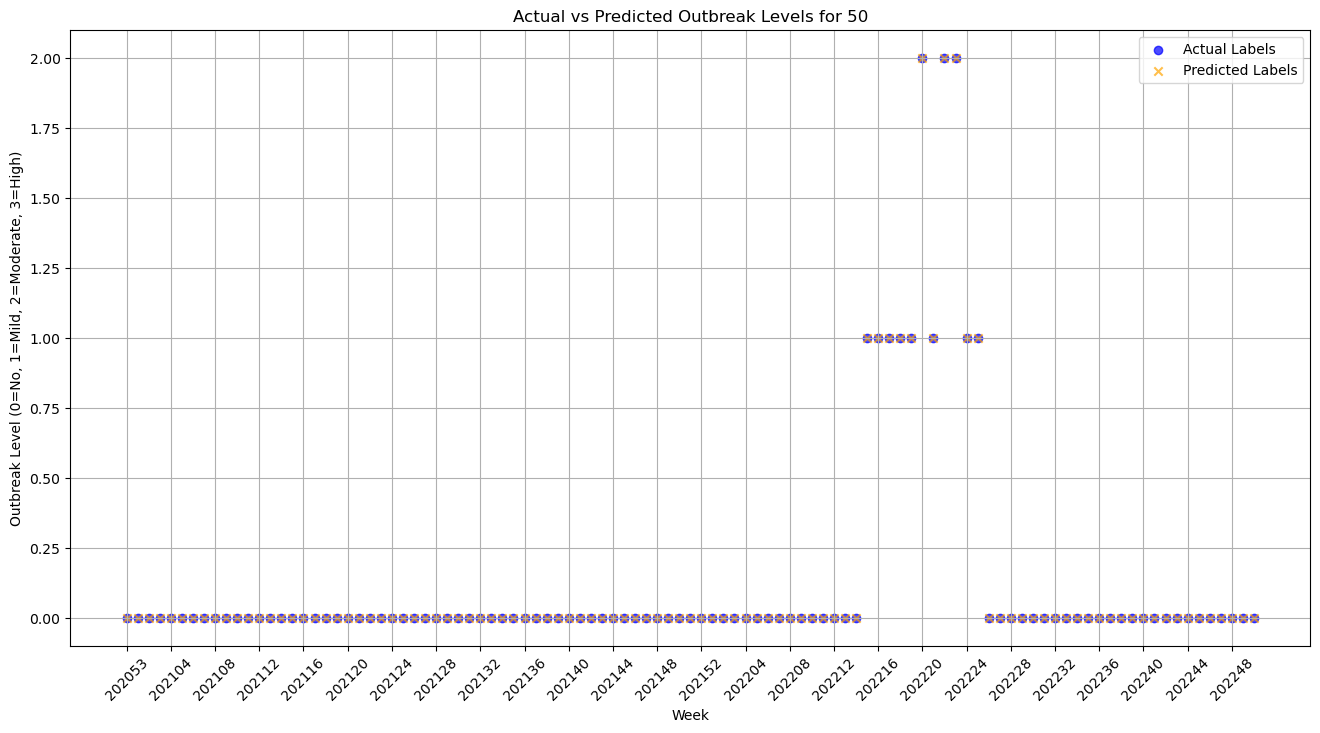

City: 56, Accuracy: 1.0000
Unique classes for 56: [0 1 2]
Classification Report for 56:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       101
        Mild       1.00      1.00      1.00         1
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 56:
[[101   0   0]
 [  0   1   0]
 [  0   0   1]]


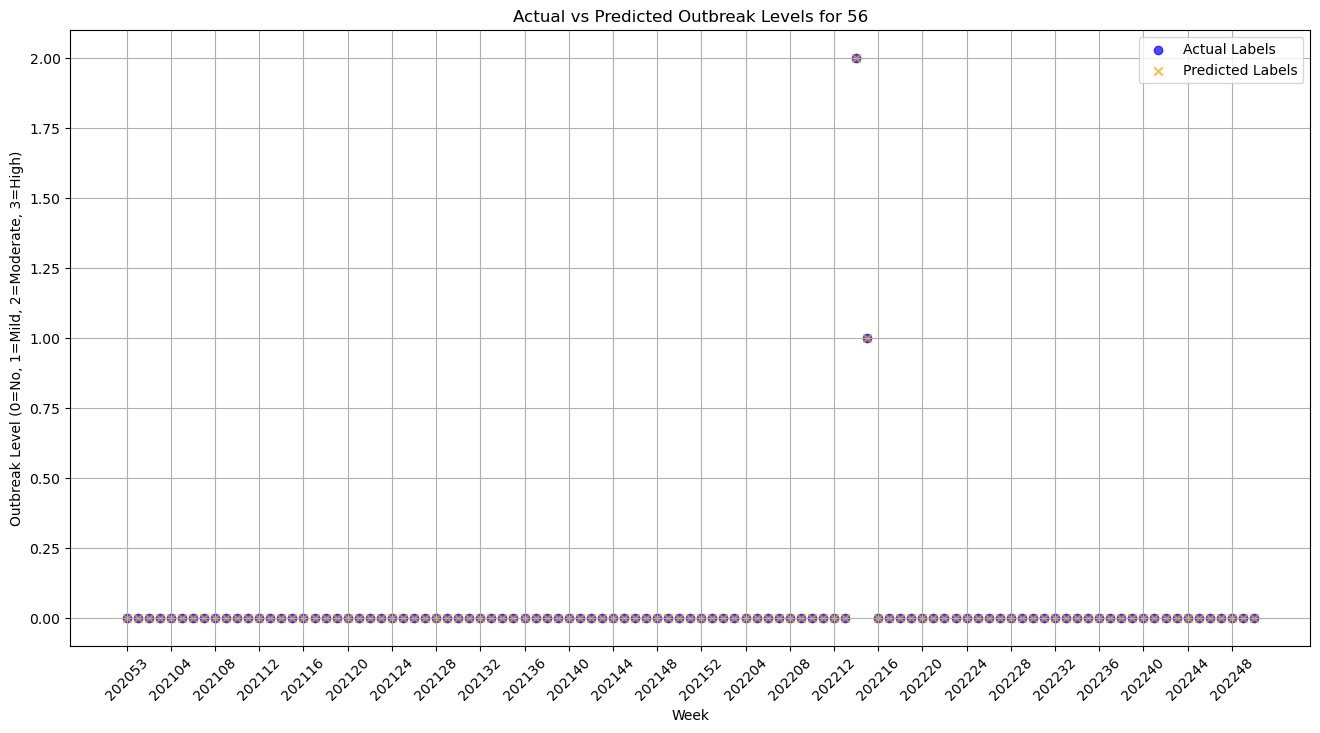

City: 58, Accuracy: 1.0000
Unique classes for 58: [0 1 2]
Classification Report for 58:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        99
        Mild       1.00      1.00      1.00         3
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 58:
[[99  0  0]
 [ 0  3  0]
 [ 0  0  1]]


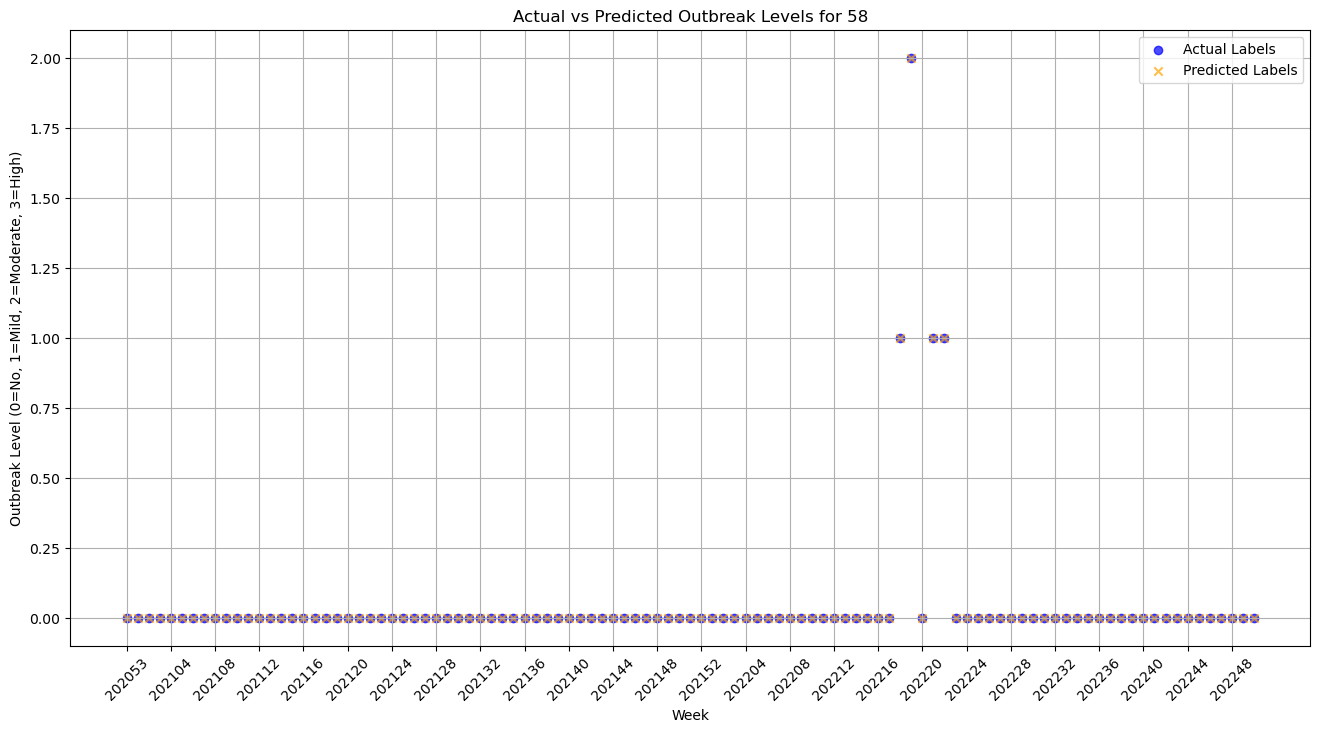

City: 60, Accuracy: 1.0000
Unique classes for 60: [0 1]
Classification Report for 60:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        98
        Mild       1.00      1.00      1.00         5

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 60:
[[98  0]
 [ 0  5]]


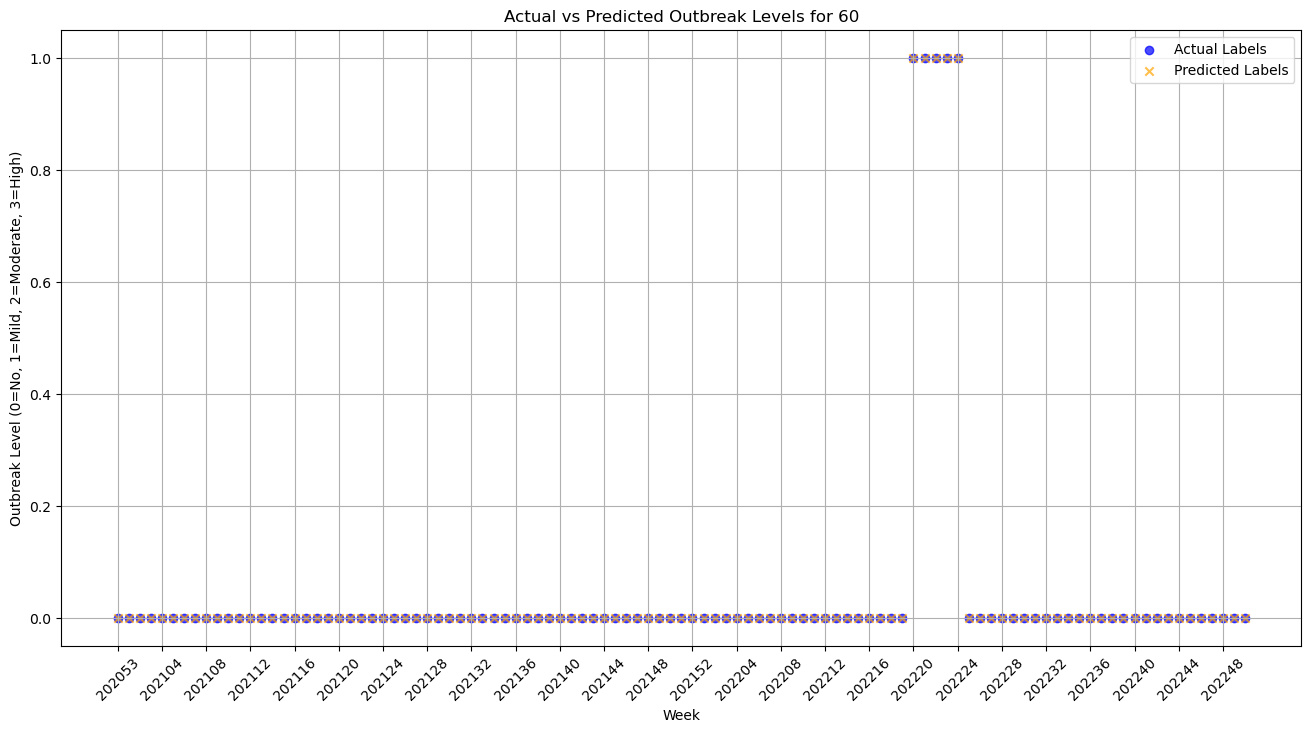

City: 68, Accuracy: 1.0000
Unique classes for 68: [0 1 2]
Classification Report for 68:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        99
        Mild       1.00      1.00      1.00         3
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 68:
[[99  0  0]
 [ 0  3  0]
 [ 0  0  1]]


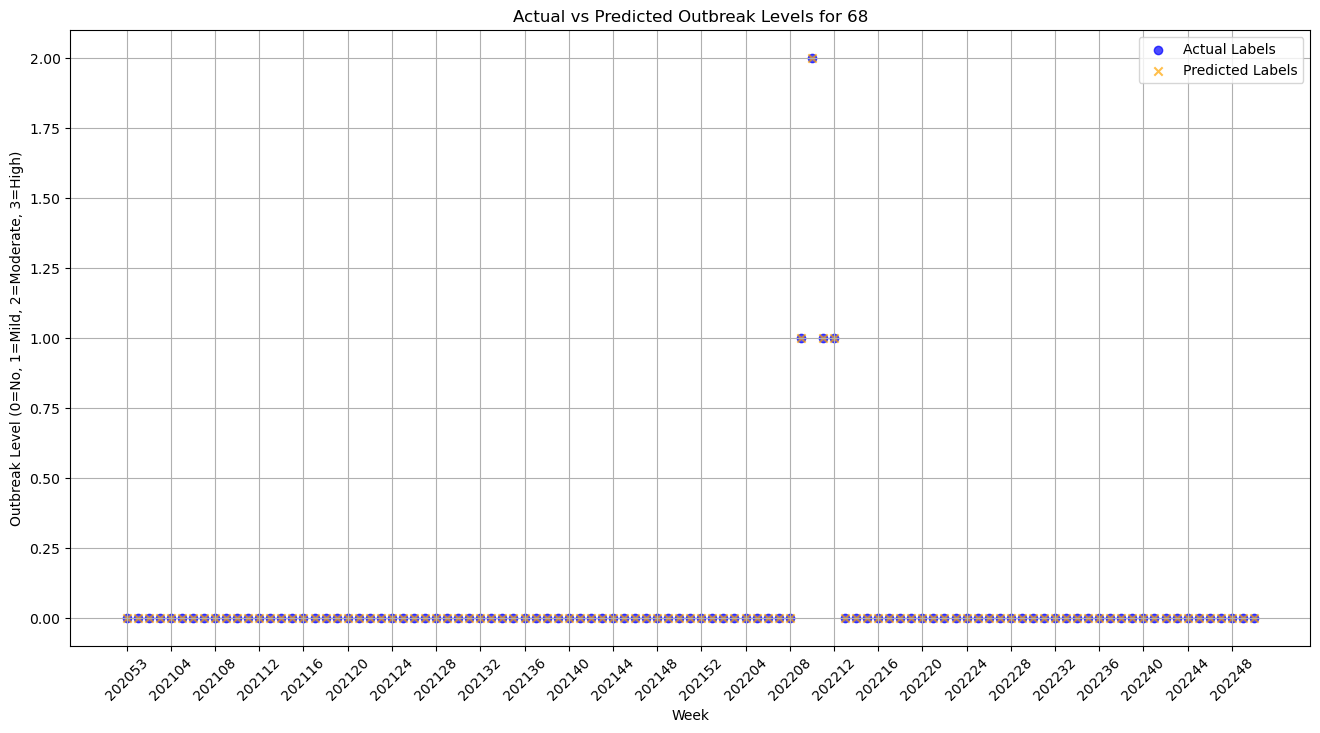

City: 77, Accuracy: 1.0000
Unique classes for 77: [0 1 2]
Classification Report for 77:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        94
        Mild       1.00      1.00      1.00         7
    Moderate       1.00      1.00      1.00         2

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Confusion Matrix for 77:
[[94  0  0]
 [ 0  7  0]
 [ 0  0  2]]


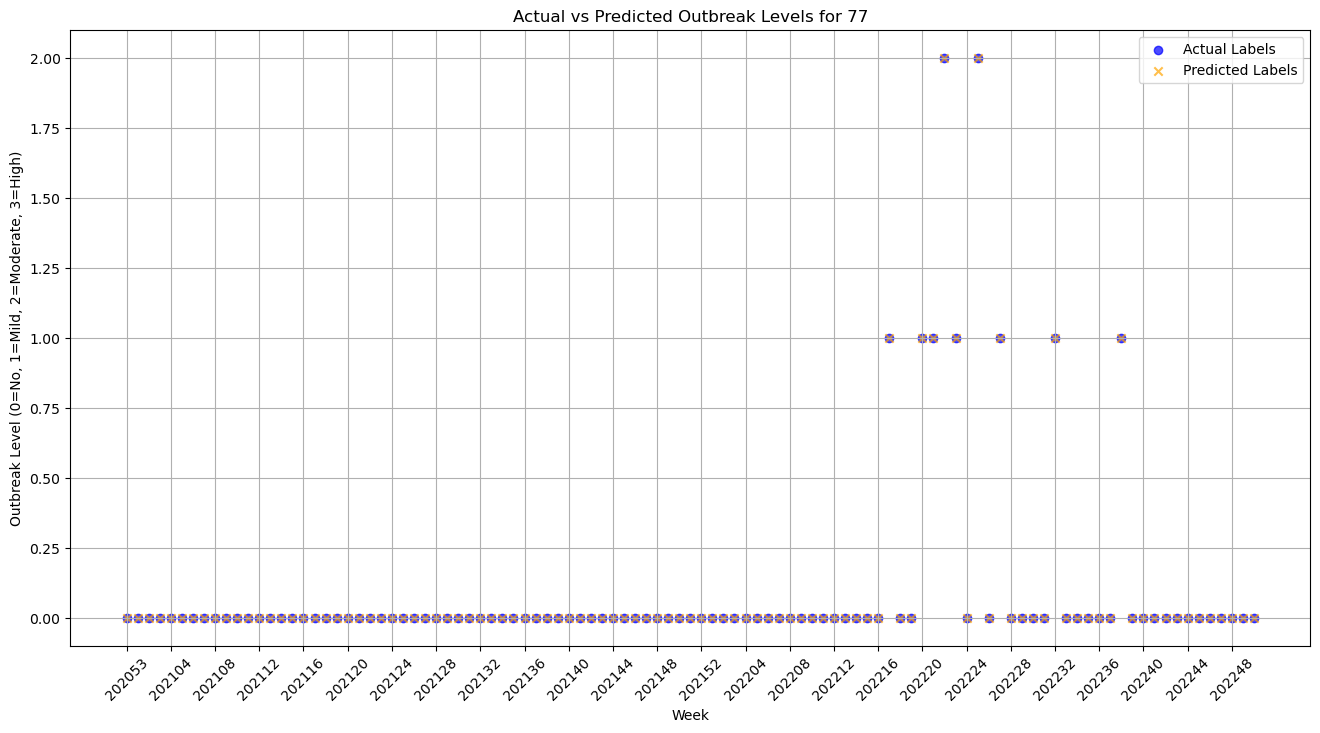

In [270]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'city_encoded' and 'week' are present in X_test
cities = X_test['city_encoded'].unique()

for city in cities:
    # Filter data for the city
    city_indices = X_test['city_encoded'] == city
    y_actual_city = y_test[city_indices]
    y_pred_city = y_pred[city_indices]
    weeks_city = X_test['week'][city_indices].astype(str)

    # Skip the city if the maximum actual outbreak level is less than 1 (i.e., No outbreak)
    if np.max(y_actual_city) < 1:
        continue

    # Compute accuracy for the city
    accuracy_city = accuracy_score(y_actual_city, y_pred_city)
    print(f'City: {city}, Accuracy: {accuracy_city:.4f}')

    # Check unique classes in actual and predicted values
    unique_classes = np.unique(y_actual_city)
    print(f'Unique classes for {city}: {unique_classes}')

    # Define target names based on unique classes
    target_names = ['No', 'Mild', 'Moderate', 'High']
    if len(unique_classes) < len(target_names):
        target_names = target_names[:len(unique_classes)]

    # Classification report
    print(f"Classification Report for {city}:")
    print(classification_report(y_actual_city, y_pred_city, target_names=target_names))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_actual_city, y_pred_city)
    print(f"Confusion Matrix for {city}:")
    print(conf_matrix)

    # Plot for the city with weeks on the x-axis
    plt.figure(figsize=(16, 8))
    plt.scatter(weeks_city, y_actual_city, label='Actual Labels', color='blue', alpha=0.7, marker='o')
    plt.scatter(weeks_city, y_pred_city, label='Predicted Labels', color='orange', alpha=0.7, marker='x')
    plt.xlabel('Week')
    plt.ylabel('Outbreak Level (0=No, 1=Mild, 2=Moderate, 3=High)')
    plt.title(f'Actual vs Predicted Outbreak Levels for {city}')
    plt.legend()
    plt.grid(True)

    # Select every 4th week for x-axis labels
    ticks = weeks_city[::4]  # Select every 4th week
    plt.xticks(ticks, rotation=45)  # Rotate x-axis labels for readability
    plt.show()